In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

**SEJ OPDAGELSE TIL PORTFOLIET**

Hvis man bare stacker lineære lag på hinanden, gør det ikke netværket bedre!
\begin{align}
    y &= w_3(w_2(w_1x+b_1)+b_2)+b_3 \\
    &= (w_3w_2w_1)x + (w_3w_2b_1) + w_3b_2 + b_3 \\
    &= w'x + b'
\end{align}

Altså er et arbitrært antal lineære lag anvendt på hinanden til slut bare et enkelt lineært lag.

Hvis man inkluderer en activation function,
\begin{align}
    y &= w_3(w_2f_1(w_1x+b_1)+b_2)+b_3,
\end{align}
er det ikke længere det samme. Her gør det en forskel at stacke flere lineære lag på!

In [2]:
def do_one_fit(Model, ax, x_train, y_train, x_test, text_with_params=False, learning_rate=0.01, steps=5000, print_results=False, **kwargs):
    model = Model()

    # for name, parameter in model.named_parameters():
    #     print(name, parameter.shape, parameter.data)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = torch.nn.MSELoss()

    for i in tqdm(range(steps), desc='Training'):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

        # if (i+1) % 1000 == 0:
        #     print(f'Step [{i+1}/{steps}], Loss: {loss_value.item():.4f}')
    
    if print_results:
        for name, parameter in model.named_parameters():
            print(f'Name: {name}, Parameters: {parameter.shape}, {parameter.data}, loss: {loss_value.item():.4f}')
    
    with torch.no_grad():
        ax.plot(x_test, model(x_test))
        ax.plot(x_train, y_train, 'o')
    ax.grid(alpha=0.5)
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    ax.set(**kwargs)
    if text_with_params:
        text = ''
        for name, parameter in model.named_parameters():
            if text != '':
                text += '\n'
            text += f'{name}: {parameter.item():.3f}'
        ax.text(0.05, 0.8, text, transform=ax.transAxes, backgroundcolor='white')

In [3]:
# Training data
f = lambda x: x - 0.5
def g(x):
    x0 = 1.25
    return torch.where(x>x0, f(x), f(x0))

x_train = torch.tensor([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4., ])
y_train = g(x_train)

x_test = torch.linspace(-2, 5, 100)

### 5.2 ReLU

Training: 100%|██████████| 5000/5000 [00:02<00:00, 1982.23it/s]


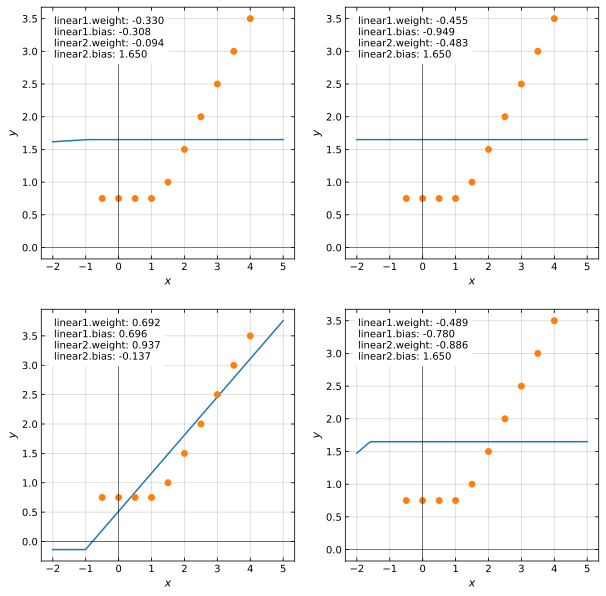

In [4]:
class LinearReluLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(1, 1)
        self.linear2 = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        x = x.view(-1, 1)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x.flatten()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax in axs.flatten():
    do_one_fit(LinearReluLinear, ax, x_train, y_train, x_test, text_with_params=True, xlabel='$x$', ylabel='$y$')

fig.savefig('ex49_fig1.png')

### 5.3 LeakyReLU

Training: 100%|██████████| 10000/10000 [00:05<00:00, 1945.09it/s]


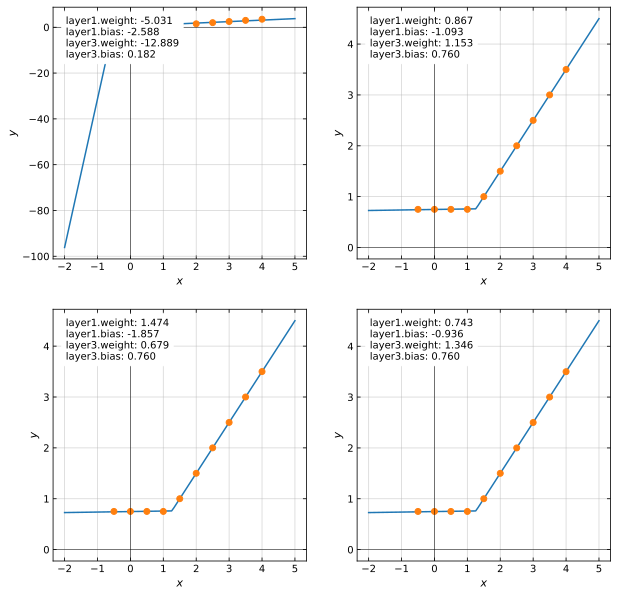

In [5]:
class LinearLeakyreluLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 1)
        self.layer2 = torch.nn.LeakyReLU()
        self.layer3 = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        x = x.view(-1, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x.flatten()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax in axs.flatten():
    do_one_fit(LinearLeakyreluLinear, ax, x_train, y_train, x_test, text_with_params=True, steps=10000, xlabel='$x$', ylabel='$y$')

fig.savefig('ex49_fig2.png')

### 5.4 SiLU

Training: 100%|██████████| 10000/10000 [00:05<00:00, 1887.55it/s]


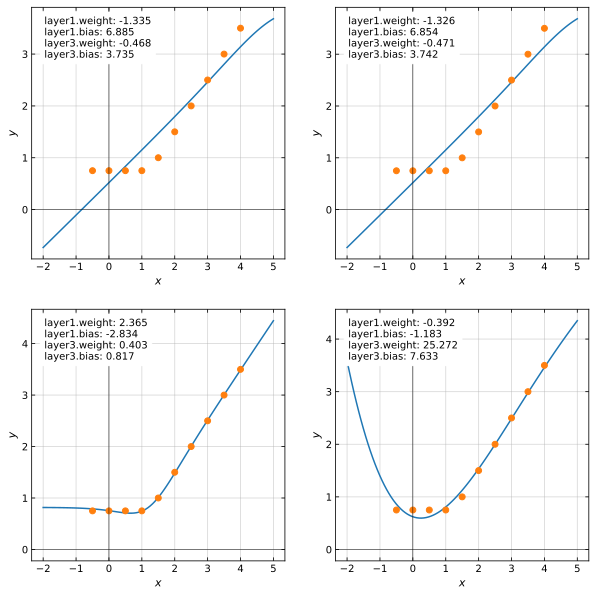

In [6]:
class LinearSiluLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 1)
        self.layer2 = torch.nn.SiLU()
        self.layer3 = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        x = x.view(-1, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x.flatten()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax in axs.flatten():
    do_one_fit(LinearSiluLinear, ax, x_train, y_train, x_test, text_with_params=True, steps=10000, xlabel='$x$', ylabel='$y$')

fig.savefig('ex49_fig3.png')

### 5.5 Softplus

Training: 100%|██████████| 10000/10000 [00:05<00:00, 1905.96it/s]


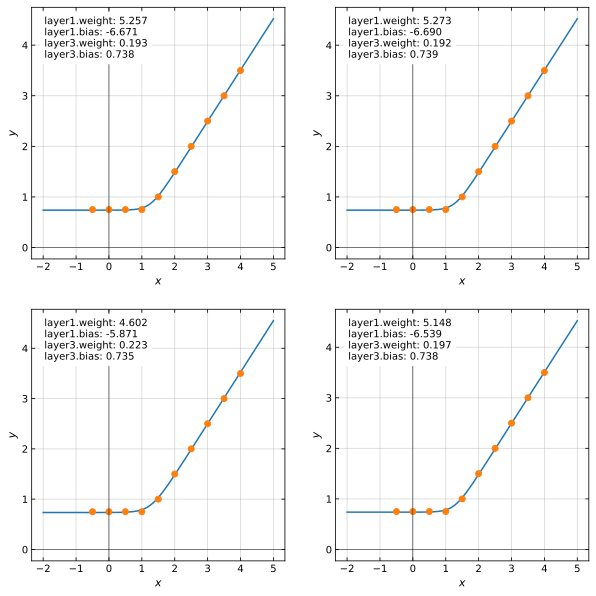

In [7]:
class LinearSoftplusLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 1)
        self.layer2 = torch.nn.Softplus()
        self.layer3 = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        x = x.view(-1, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x.flatten()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax in axs.flatten():
    do_one_fit(LinearSoftplusLinear, ax, x_train, y_train, x_test, text_with_params=True, steps=10000, xlabel='$x$', ylabel='$y$')

fig.savefig('ex49_fig4.png')

### 5.6 Large model

Training: 100%|██████████| 10000/10000 [00:05<00:00, 1969.68it/s]


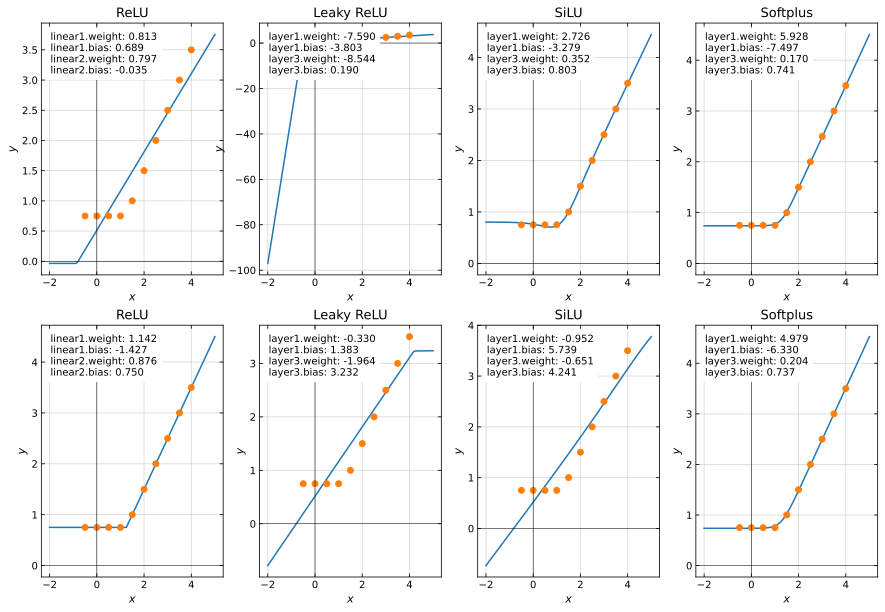

In [8]:
models = [LinearReluLinear, LinearLeakyreluLinear, LinearSiluLinear, LinearSoftplusLinear]
titles = ['ReLU', 'Leaky ReLU', 'SiLU', 'Softplus']
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for row in axs:
    for ax, model, title in zip(row, models, titles):
        do_one_fit(model, ax, x_train, y_train, x_test, text_with_params=True, steps=10000, xlabel='$x$', ylabel='$y$', title=title)

fig.savefig('ex49_fig5.png')